
# Refrence
> F. Tong and Y. Zhang, “Spectral–spatial and cascaded multilayer random forests for tree species classification in airborne hyperspectral images,” IEEE Transactions on Geoscience and Remote Sensing, vol. 60, pp. 1–11, 2022.



In [2]:
# !pip install "numpy<2.0" --force-reinstall
!pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12 cuml-cu12
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --force-reinstall

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.2/581.2 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.5/366.5 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cusparse-cu12
    Found existing installation: nvidia-cusparse-cu12 12.1.0.106
    Uninstalling nvidia-cusparse-cu12-12.1.0.106:
      Successfully uninstalled nvidia-cusparse-cu12-12.1.0.106
  Attempting uninstall: nvidia-curand-cu12
    Found existing i

In [2]:
!pip install rasterio

In [2]:
import os
import joblib
import ssl
import gc
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # Progress bars

# Image Processing
from skimage.segmentation import slic
from skimage.util import view_as_windows

# ML & Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA # Only used for init logic, not training

# PyTorch (Data Loading)
import torch
from torch.utils.data import Dataset
import rasterio
import zipfile
import urllib.request

# GPU Acceleration (RAPIDS)
try:
    import cuml
    from cuml.ensemble import RandomForestClassifier
    import cupy as cp
    print(f"✅ RAPIDS Detected: cuML {cuml.__version__}")
except ImportError:
    raise ImportError("RAPIDS not found! Did you install and RESTART the runtime?")
warnings.filterwarnings("ignore")
ssl._create_default_https_context = ssl._create_unverified_context

✅ RAPIDS Detected: cuML 25.10.00


# Organization
---

## Hyper parameters

In [3]:
CONFIG = {
    'scales': [30, 50, 100],       # Segmentation scales
    'T': 7,                    # Patch size (7x7)
    'n_trees_stage1': 200,     # Stronger priors
    'n_trees_stage2': 25,      # Trees per spatial forest (x49 forests)
    'n_cascade_levels': 3,     # Depth of Deep Forest
    'n_classes': 4,            # Reduced classes
    'n_jobs': -1,
    'batch_size_stage2': 200,  # Safe batch size for GPU VRAM
    'subsample_rate': 0.1      # Keep 30% of pixels to prevent overfitting/OOM
}

In [4]:
TARGET_CLASSES = {0: "Water", 1: "Urban", 2: "Agri", 3: "Veg"}
EUROSAT_MAP = {
    'River': 0, 'SeaLake': 0,
    'Residential': 1, 'Industrial': 1, 'Highway': 1,
    'AnnualCrop': 2, 'PermanentCrop': 2, 'Pasture': 2,
    'Forest': 3, 'HerbaceousVegetation': 3
}

## Classes

### Data Wrapper

In [5]:
class HyperImage:
    """Lightweight wrapper for image data"""
    def __init__(self, data, label=None):
        self.raw = data.astype(np.float32) # Ensure float32 for GPU
        self.label = label
        self.pca = None
        self.segments = {}
        self.stage1_probs = None

class EgyptEuroSAT_Multispectral(Dataset):
    def __init__(self, root_dir, download=True, transform=None):
        self.root = root_dir
        self.transform = transform
        self.samples = []
        self.classes = []

        # Target Egypt mapping
        self.EUROSAT_MAP = {
            'River': 0, 'SeaLake': 0,
            'Residential': 1, 'Industrial': 1, 'Highway': 1,
            'AnnualCrop': 2, 'PermanentCrop': 2, 'Pasture': 2,
            'Forest': 3, 'HerbaceousVegetation': 3
        }

        # 1. Download Logic
        url = "http://madm.dfki.de/files/sentinel/EuroSATallBands.zip"
        zip_path = os.path.join(root_dir, "EuroSATallBands.zip")
        extract_path = os.path.join(root_dir, "EuroSATallBands") # Folder name inside zip usually 'ds/images/remote_sensing/otherDatasets/sentinel_2/tif' structure

        if download:
            if not os.path.exists(root_dir):
                os.makedirs(root_dir)

            if not os.path.exists(os.path.join(root_dir, "ds")): # Check if already extracted
                print("Downloading Multispectral EuroSAT (2GB)... this may take time.")
                if not os.path.exists(zip_path):
                    urllib.request.urlretrieve(url, zip_path)

                print("Extracting...")
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(root_dir)

        # 2. Indexing Files
        # The zip extracts to a messy path, usually: root_dir/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/
        # We need to find where the class folders are.
        base_path = ""
        for root, dirs, files in os.walk(root_dir):
            if "AnnualCrop" in dirs: # Found the class folders
                base_path = root
                break

        print(f"Loading data from: {base_path}")

        for class_name in self.EUROSAT_MAP.keys():
            class_dir = os.path.join(base_path, class_name)
            if not os.path.exists(class_dir):
                continue

            target_label = self.EUROSAT_MAP[class_name]

            for fname in os.listdir(class_dir):
                if fname.endswith('.tif'):
                    self.samples.append((os.path.join(class_dir, fname), target_label))

        print(f"✅ Loaded {len(self.samples)} Multispectral images.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        # Open 13-band TIF
        with rasterio.open(path) as src:
            # Read all 13 bands
            # Shape becomes (13, 64, 64)
            image = src.read().astype(np.float32)

        # Convert to Tensor-compatible format (C, H, W) is default for rasterio read()
        # But we usually return Tensor
        image_tensor = torch.from_numpy(image)

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

### SSCMRF Model

In [6]:
class SSCMRF:
    def __init__(self, config):
        self.cfg = config
        self.scaler = MinMaxScaler()

        # FIX: Re-initialize PCA for Superpixel generation
        # We need to squash 13 bands -> 3 bands just for the SLIC segmenter
        self.pca_transformer = PCA(n_components=3)

        # Stage 1: GPU Random Forest
        self.stage1_clf = RandomForestClassifier(
            n_estimators=config['n_trees_stage1'],
            max_depth=16,
            n_streams=1,
            output_type='numpy'
        )
        self.stage2_forests = []

    def preprocess_dataset(self, hyper_images):
        """
        Global Normalization & PCA.
        - Scales 13 bands to 0-1 range.
        - Computes PCA (13->3) for Superpixel generation only.
        """
        print("[Step 1] Normalizing & Computing PCA for 13-Band Data...")

        # 1. Fit Scaler (Global Min/Max)
        subset_size = min(len(hyper_images), 1000)
        # Flatten: (N, H, W, 13) -> (N*H*W, 13)
        all_pixels = np.vstack([img.raw.reshape(-1, img.raw.shape[-1]) for img in hyper_images[:subset_size]])
        self.scaler.fit(all_pixels)

        # 2. Fit PCA (13 -> 3)
        # We subsample pixels to fit PCA quickly (fitting on 100M pixels is slow)
        pca_subset = all_pixels[np.random.choice(all_pixels.shape[0], 10000, replace=False)]
        self.pca_transformer.fit(pca_subset)

        print("   Applying transforms...")
        for img in hyper_images:
            h, w, c = img.raw.shape

            # A. Normalize Raw Data (Keep all 13 bands for Training)
            norm_flat = self.scaler.transform(img.raw.reshape(-1, c))
            img.raw = norm_flat.reshape(h, w, c).astype(np.float32)

            # B. Create PCA version (13 -> 3) for SLIC Segmentation
            # SLIC works best on 3-channel (LAB/RGB) images
            pca_flat = self.pca_transformer.transform(norm_flat)
            img.pca = pca_flat.reshape(h, w, 3).astype(np.float32)

    def run_stage1(self, hyper_images, is_training=True):
        """Generates Superpixels and Probability Priors"""
        desc = "Training Stage 1" if is_training else "Inferencing Stage 1"
        print(f"[Step 2] {desc}...")

        X_feats, y_labels = [], []

        # 1. Superpixel Segmentation
        # Note: We use img.pca (3 bands) for segmentation, but img.raw (13 bands) for features
        for img in tqdm(hyper_images, desc="Segmentation"):
            h, w = img.pca.shape[:2]
            scale_accum = np.zeros((h, w, self.cfg['n_classes']))

            for scale in self.cfg['scales']:
                # SLIC runs on the PCA (3-band) image
                segments = slic(img.pca, n_segments=scale, compactness=10, start_label=0)
                img.segments[scale] = segments

                unique_segs = np.unique(segments)

                # Extract mean spectral signature (13 bands) per segment
                seg_means = []
                for seg_idx in unique_segs:
                    mask = (segments == seg_idx)
                    # CRITICAL: We take the mean of the 13-band RAW data
                    mean_spectrum = img.raw[mask].mean(axis=0)
                    seg_means.append(mean_spectrum)

                    if is_training:
                        X_feats.append(mean_spectrum)
                        y_labels.append(img.label)

                # If Inferencing, predict immediately
                if not is_training:
                    seg_means_np = np.array(seg_means, dtype=np.float32)
                    probs = self.stage1_clf.predict_proba(seg_means_np)

                    # Project back to image
                    prob_map = np.zeros((h, w, self.cfg['n_classes']))
                    for i, seg_idx in enumerate(unique_segs):
                        prob_map[segments == seg_idx] = probs[i]
                    scale_accum += prob_map

            if not is_training:
                img.stage1_probs = scale_accum / len(self.cfg['scales'])

        # 2. Train Stage 1
        if is_training:
            print(f"   Fitting Stage 1 RF on {len(X_feats)} segments...")
            X_np = np.array(X_feats, dtype=np.float32)
            y_np = np.array(y_labels, dtype=np.float32)
            self.stage1_clf.fit(X_np, y_np)

            # Generate priors for training set
            print("   Generating training priors...")
            for img in tqdm(hyper_images, desc="Priors"):
                h, w = img.pca.shape[:2]
                scale_accum = np.zeros((h, w, self.cfg['n_classes']))
                for scale in self.cfg['scales']:
                    segments = img.segments[scale]
                    unique_segs = np.unique(segments)
                    seg_means = [img.raw[segments == s].mean(axis=0) for s in unique_segs]

                    probs = self.stage1_clf.predict_proba(np.array(seg_means, dtype=np.float32))

                    prob_map = np.zeros((h, w, self.cfg['n_classes']))
                    for i, s in enumerate(unique_segs):
                        prob_map[segments == s] = probs[i]
                    scale_accum += prob_map
                img.stage1_probs = scale_accum / len(self.cfg['scales'])

    def _extract_patches(self, img, pad_width):
        """Helper to get 7x7 windows + priors"""
        # Pad Raw (13 ch) and Probs (4 ch)
        p_raw = np.pad(img.raw, ((pad_width,)*2, (pad_width,)*2, (0,0)), mode='reflect')
        p_prob = np.pad(img.stage1_probs, ((pad_width,)*2, (pad_width,)*2, (0,0)), mode='reflect')

        T = self.cfg['T']
        raw_win = view_as_windows(p_raw, (T, T, p_raw.shape[2])).reshape(-1, T, T, p_raw.shape[2])

        center_probs = img.stage1_probs.reshape(-1, self.cfg['n_classes'])
        tiled_probs = np.tile(center_probs[:, None, None, :], (1, T, T, 1))

        return np.concatenate([raw_win, tiled_probs], axis=-1)

    def train_stage2(self, train_imgs):
        print(f"[Step 3] Training Stage 2 (Deep Forest) - Streaming Mode...")

        T = self.cfg['T']
        pad = T // 2
        n_pixels_patch = T * T

        # GPU Accumulators
        X_gpu_chunks = []
        y_gpu_chunks = []

        # 1. Stream Data to GPU
        chunk_size = self.cfg['batch_size_stage2']
        n_chunks = int(np.ceil(len(train_imgs) / chunk_size))

        # FIX: Use tqdm here instead of range() so you see the bar!
        for i in tqdm(range(n_chunks), desc="Streaming Data to GPU"):
            batch = train_imgs[i*chunk_size : (i+1)*chunk_size]

            batch_feats, batch_labels = [], []
            for img in batch:
                feats = self._extract_patches(img, pad)
                feats_flat = feats.reshape(feats.shape[0], n_pixels_patch, -1)

                # Subsample to save VRAM
                n_keep = int(feats_flat.shape[0] * self.cfg['subsample_rate'])
                if n_keep > 0:
                    idx = np.random.choice(feats_flat.shape[0], n_keep, replace=False)
                    batch_feats.append(feats_flat[idx])
                    batch_labels.append(np.full(n_keep, img.label))

            # Stack on CPU -> Move to GPU -> Delete CPU
            if batch_feats:
                X_small = np.vstack(batch_feats).astype(np.float32)
                y_small = np.concatenate(batch_labels).astype(np.float32)
                X_gpu_chunks.append(cp.asarray(X_small))
                y_gpu_chunks.append(cp.asarray(y_small))
                del X_small, y_small
                gc.collect() # Force cleanup per chunk

        print("\n   Merging data on GPU VRAM...")
        X_gpu_all = cp.vstack(X_gpu_chunks)
        y_gpu_all = cp.concatenate(y_gpu_chunks)
        del X_gpu_chunks, y_gpu_chunks
        gc.collect()

        # 2. Train Forests
        self.stage2_forests = []
        for level in range(self.cfg['n_cascade_levels']):
            print(f"   --- Training Level {level+1} ---")
            level_clfs = []

            # Train 49 spatial forests
            for k in tqdm(range(n_pixels_patch), desc=f"Level {level+1} Forests"):
                X_k_gpu = X_gpu_all[:, k, :]
                clf = RandomForestClassifier(
                    n_estimators=self.cfg['n_trees_stage2'],
                    max_depth=12,
                    n_streams=1,
                    output_type='numpy',
                    verbose=0
                )
                clf.fit(X_k_gpu, y_gpu_all)
                level_clfs.append(clf)
            self.stage2_forests.append(level_clfs)

        # Clear GPU Memory
        del X_gpu_all, y_gpu_all
        cp.get_default_memory_pool().free_all_blocks()

    def predict(self, test_imgs):
        print("[Inference] Running Cascade...")
        T = self.cfg['T']
        pad = T // 2
        n_pixels_patch = T * T
        preds = []

        for img in tqdm(test_imgs, desc="Predicting"):
            feats = self._extract_patches(img, pad)
            feats_flat = feats.reshape(feats.shape[0], n_pixels_patch, -1)
            accum_probs = np.zeros((feats_flat.shape[0], self.cfg['n_classes']))

            for level in range(self.cfg['n_cascade_levels']):
                level_probs = np.zeros_like(accum_probs)
                for k in range(n_pixels_patch):
                    X_input = feats_flat[:, k, :].astype(np.float32)
                    p = self.stage2_forests[level][k].predict_proba(X_input)

                    if p.shape[1] < self.cfg['n_classes']:
                        full_p = np.zeros((p.shape[0], self.cfg['n_classes']))
                        full_p[:, :p.shape[1]] = p
                        p = full_p
                    level_probs += p
                accum_probs += (level_probs / n_pixels_patch)

            final_img_prob = np.sum(accum_probs, axis=0)
            preds.append(np.argmax(final_img_prob))

        return preds

    def acc_predict(self, test_imgs, batch_size=200):
        print(f"[Inference] Predicting on {len(test_imgs)} images (Batched Mode)...")
        T = self.cfg['T']
        pad = T // 2
        n_pixels_patch = T * T
        n_classes = self.cfg['n_classes']

        final_preds = []

        # 1. Process in Batches
        # processing 200 images at once is ~100x faster than 1 by 1
        n_batches = int(np.ceil(len(test_imgs) / batch_size))

        for b in tqdm(range(n_batches), desc="Inference Batches"):
            start = b * batch_size
            end = min((b + 1) * batch_size, len(test_imgs))
            batch = test_imgs[start:end]

            # A. Extract Features for the whole batch
            # We list comprehension to get all features, then stack them
            batch_feats = [self._extract_patches(img, pad) for img in batch]

            # Stack into one massive array: (Batch_Size * 4096, 49, Features)
            # 200 imgs * 64*64 = 819,200 pixels. This fits easily in GPU RAM.
            X_cpu = np.vstack(batch_feats).reshape(-1, n_pixels_patch, batch_feats[0].shape[-1])
            X_gpu = cp.asarray(X_cpu, dtype=np.float32)

            # B. Cascade Prediction (Vectorized)
            # Accumulator for probabilities: (Total_Pixels, N_Classes)
            accum_probs = cp.zeros((X_gpu.shape[0], n_classes), dtype=np.float32)

            for level in range(self.cfg['n_cascade_levels']):
                level_probs = cp.zeros_like(accum_probs)

                for k in range(n_pixels_patch):
                    # Get feature slice for k-th spatial position across ALL images
                    X_k = X_gpu[:, k, :]

                    # Predict on GPU
                    # cuml returns cp.ndarray
                    p = self.stage2_forests[level][k].predict_proba(X_k)

                    # C. Robust Handling (Missing Classes)
                    # Sometimes a forest hasn't seen all classes. We must pad.
                    if p.shape[1] < n_classes:
                        # Create full size array
                        p_full = cp.zeros((p.shape[0], n_classes), dtype=np.float32)

                        # We need to know WHICH classes are present.
                        # cuml RandomForest stores this in .classes_ (usually on host)
                        known_classes = self.stage2_forests[level][k].classes_

                        # Use fancy indexing to place columns in right spots
                        # We must move known_classes to GPU for indexing
                        known_classes_gpu = cp.asarray(known_classes, dtype=np.int32)
                        p_full[:, known_classes_gpu] = p
                        p = p_full

                    level_probs += p

                # Average across spatial forests
                accum_probs += (level_probs / n_pixels_patch)

            # C. Aggregate to Image Level
            # Average across levels
            final_pixel_probs = accum_probs / self.cfg['n_cascade_levels']

            # Reshape back to (Batch_Size, Pixels_Per_Image, Classes)
            # Pixels_Per_Image = 64 * 64 = 4096
            n_pixels_img = 64 * 64
            batch_probs_reshaped = final_pixel_probs.reshape(len(batch), n_pixels_img, n_classes)

            # Sum pixels -> Argmax -> Label
            # axis 1 is the pixel dimension
            img_sum = cp.sum(batch_probs_reshaped, axis=1)
            batch_preds = cp.argmax(img_sum, axis=1)

            # Move result to CPU list
            final_preds.extend(batch_preds.get().tolist())

            # Clean GPU Mem
            del X_gpu, accum_probs, level_probs, batch_probs_reshaped

        return final_preds

# Run Model

## Data Preparation

In [6]:
# 1. Load Data
dataset = EgyptEuroSAT_Multispectral(root_dir='./data')

Extracting...
Loading data from: ./data/ds/images/remote_sensing/otherDatasets/sentinel_2/tif
✅ Loaded 27000 Multispectral images.


In [7]:
# 2. Sample
indices = np.random.permutation(len(dataset))[:6000]
subset = [dataset[i] for i in indices]

In [8]:
def convert_to_hyperimage(dataset_samples):
    hyper_images = []
    for img_tensor, label in dataset_samples:
        # Pytorch/Rasterio is (13, 64, 64) -> We need (64, 64, 13)
        img_np = img_tensor.permute(1, 2, 0).numpy()
        hyper_images.append(HyperImage(img_np, label=label))
    return hyper_images

In [9]:
# 3. Convert to HyperImage
print(f"Converting {len(subset)} images...")
hyper_images = convert_to_hyperimage(subset)
hyper_data = [HyperImage(img.permute(1,2,0).numpy(), label=lbl) for img, lbl in subset]

Converting 6000 images...


In [10]:
# 4. Split
split = int(len(hyper_data) * 0.7)
train_data = hyper_data[:split]
test_data = hyper_data[split:]
print(f"Train: {len(train_data)} | Test: {len(test_data)}")

Train: 4200 | Test: 1800


## Model Fitting

In [32]:
# 5. Run Model
model = SSCMRF(CONFIG)
model.preprocess_dataset(train_data + test_data)
model.run_stage1(train_data, is_training=True)
model.run_stage1(test_data, is_training=False)

[Step 1] Normalizing & Computing PCA for 13-Band Data...
   Applying transforms...
[Step 2] Training Stage 1...


Segmentation:   0%|          | 0/4200 [00:00<?, ?it/s]

   Fitting Stage 1 RF on 767403 segments...
   Generating training priors...


Priors:   0%|          | 0/4200 [00:00<?, ?it/s]

[Step 2] Inferencing Stage 1...


Segmentation:   0%|          | 0/1800 [00:00<?, ?it/s]

In [33]:
# Clean memory before heavy training
gc.collect()

model.train_stage2(train_data)

[Step 3] Training Stage 2 (Deep Forest) - Streaming Mode...


Streaming Data to GPU:   0%|          | 0/21 [00:00<?, ?it/s]


   Merging data on GPU VRAM...
   --- Training Level 1 ---


Level 1 Forests:   0%|          | 0/49 [00:00<?, ?it/s]

   --- Training Level 2 ---


Level 2 Forests:   0%|          | 0/49 [00:00<?, ?it/s]

   --- Training Level 3 ---


Level 3 Forests:   0%|          | 0/49 [00:00<?, ?it/s]

### Freezing the model

In [34]:
# Define path on Google Drive
save_dir = '/content/drive/MyDrive/DEPI Grad Project - Land Detection'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, 'sscmrf_model_v3.pkl')

print(f"Freezing/Saving model to: {model_path} ...")
# compress=3 offers a good balance of speed and file size
joblib.dump(model, model_path, compress=3)
print("Model saved successfully!")

Freezing/Saving model to: /content/drive/MyDrive/DEPI Grad Project - Land Detection/sscmrf_model_v3.pkl ...
Model saved successfully!


## Model Evaluation

In [35]:
# 6. Evaluate
preds = model.predict(test_data)
y_true = [d.label for d in test_data]

print("\n" + "="*40)
print(f"Accuracy: {accuracy_score(y_true, preds)*100:.2f}%")
print(classification_report(y_true, preds, target_names=TARGET_CLASSES.values()))

[Inference] Running Cascade...


Predicting:   0%|          | 0/1800 [00:00<?, ?it/s]


Accuracy: 89.06%
              precision    recall  f1-score   support

       Water       0.93      0.90      0.92       365
       Urban       0.84      0.86      0.85       530
        Agri       0.88      0.88      0.88       498
         Veg       0.93      0.93      0.93       407

    accuracy                           0.89      1800
   macro avg       0.90      0.89      0.89      1800
weighted avg       0.89      0.89      0.89      1800



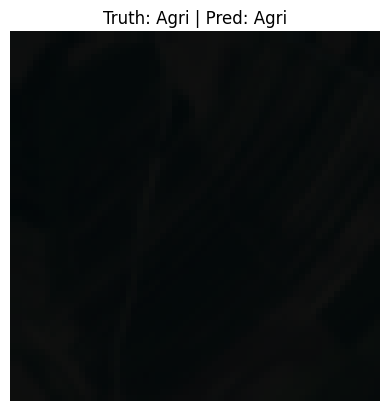

In [90]:
# Visual Check
def visual_evaluaiton(idx:int):
    plt.imshow(test_data[idx-1].raw[:,:,[3, 2, 1]])
    plt.title(f"Truth: {TARGET_CLASSES[y_true[idx-1]]} | Pred: {TARGET_CLASSES[preds[idx-1]]}")
    plt.axis('off')
    plt.show()

visual_evaluaiton(4211)

# Restoring previous model

In [1]:
load_path = '/content/drive/MyDrive/DEPI Grad Project - Land Detection/sscmrf_model_v2.pkl'
print(f"Loading model from: {load_path} ...")

loaded_model = joblib.load(load_path)
print("✅ Model restored!")

Loading model from: /content/drive/MyDrive/DEPI Grad Project - Land Detection/sscmrf_model_v2.pkl ...


NameError: name 'joblib' is not defined

In [ ]:
# 3. Verify it works (Inference only)
loaded_model.preprocess_dataset(test_data)
loaded_model.run_stage1(test_data, is_training=False)

print("Testing loaded model...")
preds = loaded_model.predict(test_data[:1000]) # Predict on first 10 images
y_true = [d.label for d in test_data[:1000]]

print("\n" + "="*40)
print(f"Accuracy: {accuracy_score(y_true, preds)*100:.2f}%")
print(classification_report(y_true, preds, target_names=TARGET_CLASSES.values()))

[Step 1] Normalizing & Computing PCA for 13-Band Data...
   Applying transforms...
[Step 2] Inferencing Stage 1...


Segmentation:   0%|          | 0/1800 [00:00<?, ?it/s]

Testing loaded model...
[Inference] Running Cascade...


Predicting:   0%|          | 0/1000 [00:00<?, ?it/s]


Accuracy: 50.90%
              precision    recall  f1-score   support

       Water       0.58      0.72      0.64       194
       Urban       0.49      0.90      0.64       311
        Agri       0.45      0.31      0.37       273
         Veg       0.75      0.03      0.05       222

    accuracy                           0.51      1000
   macro avg       0.57      0.49      0.43      1000
weighted avg       0.56      0.51      0.43      1000



In [ ]:
print("Preprocessing test data...")
loaded_model.preprocess_dataset(test_data)

# 2. Generate Priors (Stage 1)
# (Runs the first Random Forest to create probability maps)
print("Generating Stage 1 Priors...")
loaded_model.run_stage1(test_data, is_training=False)

# 3. NOW you can predict
print("Running Stage 2 Inference...")
# preds = loaded_model.acc_predict(test_data, batch_size=50)

Preprocessing test data...
[Step 1] Normalizing & Computing PCA for 13-Band Data...
   Applying transforms...
Generating Stage 1 Priors...
[Step 2] Inferencing Stage 1...


Segmentation:   0%|          | 0/1800 [00:00<?, ?it/s]

Running Stage 2 Inference...
